In [1]:
#import sys
#sys.path.insert(0, '/Users/timkrausz/Documents/GitHub/Maze-photometry-analyses/')

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.io
import statsmodels.api as sm
from sklearn.linear_model import Lasso
#from phot_funcs import *
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from TriFuncs import airPLS, WhittakerSmooth, get_zdFF

In [2]:
def transform_scatter(points, image, rotate_center=(0,0)):
    fig, ax = plt.subplots(figsize=(12,10))
    plt.subplots_adjust(left=0.25, bottom=0.25)

    ax.imshow(image, extent=[0, 640, 0, 480])
    scatter = ax.scatter(points[:,0], points[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

    axcolor = 'lightgoldenrodyellow'
    ax_scale = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    ax_translate_x = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor=axcolor)
    ax_translate_y = plt.axes([0.25, 0.0, 0.65, 0.03], facecolor=axcolor)
    ax_rotate = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

    s_scale = Slider(ax_scale, 'Scale', 0.1, 1.5, valinit=1.0)
    s_translate_x = Slider(ax_translate_x, 'Translate X', -200, 200, valinit=0)
    s_translate_y = Slider(ax_translate_y, 'Translate Y', -200, 200, valinit=0)
    s_rotate = Slider(ax_rotate, 'Rotate', -30, 30, valinit=0)

    def update(val):
        #clear_output()
        scale = s_scale.val
        translate_x = s_translate_x.val
        translate_y = s_translate_y.val
        rotate_deg = s_rotate.val

        # Scale
        scale_matrix = np.array([[scale, 0, 0],
                                 [0, scale, 0],
                                 [0, 0, 1]])

        # Translate
        translate_matrix = np.array([[1, 0, translate_x],
                                     [0, 1, translate_y],
                                     [0, 0, 1]])

        # Rotate
        rotate_rad = np.deg2rad(rotate_deg)
        rotate_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad), 0],
                                  [np.sin(rotate_rad), np.cos(rotate_rad), 0],
                                  [0, 0, 1]])

        # Rotate around specified center
        center_matrix = np.array([[1, 0, rotate_center[0]],
                                  [0, 1, rotate_center[1]],
                                  [0, 0, 1]])
        center_translate_matrix = np.array([[1, 0, -rotate_center[0]],
                                            [0, 1, -rotate_center[1]],
                                            [0, 0, 1]])
        rotate_around_center_matrix = center_translate_matrix.dot(rotate_matrix).dot(center_matrix)

        # Transform points
        transform_matrix = rotate_around_center_matrix.dot(scale_matrix).dot(translate_matrix)
        transformed_points = transform_matrix.dot(points.T).T

        # Update scatter plot
        scatter.set_offsets(transformed_points[:,:2])
        #scatter.set_color(transformed_points[:,2])

        fig.canvas.draw_idle()
        global new_coords
        new_coords = transformed_points[:,:2]
        global transformParams
        print("rotate degree, scale, x tran, y tran = ",[rotate_deg,scale,translate_x,translate_y])
        transformParams = [rotate_deg,scale,translate_x,translate_y]
        #print(transformed_points)
    s_scale.on_changed(update)
    s_translate_x.on_changed(update)
    s_translate_y.on_changed(update)
    s_rotate.on_changed(update)

    plt.show()
    
def assign_to_hexagon(x, y, centroids):
    """
    Assigns each point in the given x-y coordinate vector to the closest hexagonal region of interest
    with the specified centroids.
    Parameters:
        x (np.ndarray): A 1D numpy array of x-coordinates.
        y (np.ndarray): A 1D numpy array of y-coordinates.
        centroids (np.ndarray): A 2D numpy array of hexagonal region centroids, where each row contains
            the x and y coordinates of the centroid of a region of interest.
    Returns:
        A 1D numpy array of integers, where each element is the index of the closest centroid in the
        centroids array.
    """
    # Calculate the Euclidean distance between each point and each centroid
    x_np = np.array(x) if not isinstance(x, np.ndarray) else x
    y_np = np.array(y) if not isinstance(y, np.ndarray) else y
    distances = np.sqrt((x_np[:, np.newaxis] - centroids[:, 0])**2 + (y_np[:, np.newaxis] - centroids[:, 1])**2)
    # Find the index of the closest centroid for each point
    closest_centroid_indices = np.argmin(distances, axis=1) +1
    
    return closest_centroid_indices
    

#compute the centroids of the initial hexagons
hexlist = [2,47,46,45,44,43,3,\
49,42,41,40,39,48,\
38,37,36,35,34,33,\
32,31,30,29,28,\
27,26,25,24,23,\
22,21,20,19,\
18,17,16,15,\
14,13,12,\
11,10,9,\
8,7,\
6,5,\
4,\
1]
#hexlist = np.subtract(hexlist,1) #convert to index-based states
coords = []
cols = [7,6,6,5,5,4,4,3,3,2,2,1,1]
maxrows = 13
r = 0
x = 1
y = 1
startr = 1
while r < maxrows:
    maxcols = cols[r]
    c = 0
    if r%2!=0:
        startr+=1
    x=startr
    while c < maxcols:
        coords.append([x,y])
        x += 2
        c += 1
    if r%2!=0:
        y += 2
    else:
        y+=1
    r += 1
cents = {h: c for h,c in zip(hexlist,coords)}


# define the centroids of the hexagons
centroids = np.zeros((49,2))
for h in list(cents.keys()):
    centroids[h-1] = cents[h]

centroids[:,0] = centroids[:,0]/centroids[:,0].max()*450 +80
centroids[:,1] = centroids[:,1]/centroids[:,1].max()*410



In [3]:
noPhot = False

%matplotlib qt
animal = "IM-"+input('rat: ') #i.e. IM-1006
#filepath = "/Volumes/Tim/Photometry/"+ animal + '/'
filepath = "/Volumes/Tim-1/Photometry/"+ animal + '/'
date = input('date: ') #format: mmddyyyy
ses_type = input('Block change = prob or barrier? ')
analcolor = 'green'# input('color of dLight?')
filecount = '0'# input('file suffix number: ')
# std used for gaussian smoothing of position data. In Weill building,
# recommend using sigma = 2
gausSigma = 0.1
usePosSmoothing = False

if noPhot:
    rec_folder = input("recording folder name? (yyyy-mm-dd_hh-mm-ss)")

# # Script to create and save sampleframe and triframe to directory


import numpy as np
import pandas as pd
import ipywidgets as widgets
import ipympl
import csv
import matplotlib.pyplot as plt
import scipy.io
from sklearn.linear_model import Lasso
from scipy.signal import lfilter,resample,decimate,correlate
from matplotlib.lines import Line2D
import process_ephys_visitData
from TriFuncs import * #custom functions for following analysis
#get_ipython().run_line_magic('matplotlib', '')

#get variables from main script
from __main__ import *

#set path to access previously stored .mat files, etc. use scipy.io.loadmat()
datepath = filepath + date + '/'
savepath = datepath
phot_dlc = input('photometry DLC? y/n')

from photProcessingFuncs import *

ephysSR = 1500 #sampling rate of ephys system for vis
Fs = 250
VizGetter = process_ephys_visitData.EphysVisitGetter(animal,date,rec_folder,ephysSR)
VizGetter.prepData()
n_seconds = VizGetter.getSeshDurationInS()
# fill in nansig with nan vector of length Fs*n_seconds
nansig = np.full(int(Fs*(n_seconds+10)),np.nan)
#need to get visits from ephys data. should be 
visits = VizGetter.get_visit_times()
visits = visits[1:] - visits[0]
visits = np.unique(visits)
print(visits.astype(int))

shiftVisByN = int(input("adjust visits by removing n indices from start?"+\
    " (input n; if 1 is first index, input 1)"))
visits = visits[shiftVisByN:]

#get sample numbers of visit indices
visits = np.divide(visits,ephysSR/Fs)
visits = visits.astype(int)


#import arduino behavioral data and their timestamps
a = open(datepath+'arduinoraw'+str(filecount)+'.txt','r')
ardtext= a.read().splitlines()
a.close

with open(datepath+'ArduinoStamps'+str(filecount)+'.csv','r') as at:
    reader = csv.reader(at)
    ardtimes = list(reader)
ardtimes = [float(val) for sublist in ardtimes for val in sublist]

photstart = ardtimes[1] #time when pulse was sent to R series. 0 index for sig data
ardtimes = np.subtract(ardtimes,photstart) #make photometry start time zero

#convert ardtimes to sample number to match photometry data. 
#Target rate = 250/sec from 10 KHz initial sample rate (same as photometry)
ardstamps = np.round(ardtimes*(Fs/1000)).astype(int)

visits = visits[1:] - visits[0]
vis4pos = visits
x,y,vel,framestamps,acc,dlc_pos = align_pos_to_visits(Fs,vis4pos,datepath,
    phot_dlc=phot_dlc,filecount=filecount,gaus_smooth=usePosSmoothing,sigma=gausSigma,cutoff=0.4)

plt.figure()
plt.plot(framestamps)
plt.title("camera frame stamps in photometry sample time")


#Make dataframe with all data organized by sample number
visits = np.unique(visits)

#This is where the problem is... not the right length.
a = np.tile(0,(len(nansig),22))
data = np.full_like(a, np.nan, dtype=np.double) #make a sample number x variable number array of nans
#fill in nans with behavioral data. columns = x,y,ach,dlight,port,rwd,roi
#give signal columns dff values
data[:,2] = nansig 
data[:,3] = 0
data[:,16] = nansig
data[:,17] = 0
data[:,11] = nansig
block = 1
tris = 0
trial = 1
data[0,15] = 0
pA = np.nan
pB = np.nan
pC = np.nan
#get sample number of current trial to align phot data to port entries
#data = list(data)
#fill in reward and port info. Ports are coded by 1:A,2:B,3:C
for i in range(len(ardtext)):
    try:
        vsamp = visits[tris]
    except:
        print('end of trials reached')
    new = False
    if 'A Harvested' in ardtext[i] or "delivered at port A" in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 1
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'B Harvested' in ardtext[i] or "delivered at port B" in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 1
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'C Harvested' in ardtext[i] or "delivered at port C" in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 1
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'o Reward port A' in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 0
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'o Reward port B' in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 0
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'o Reward port C' in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 0
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'Lick at port A' in ardtext[i] or "beam break at port A" in ardtext[i]:
        data[ardstamps[i],18] = 1
    elif 'Lick at port B' in ardtext[i] or "beam break at port B" in ardtext[i]:
        data[ardstamps[i],19] = 1
    elif 'Lick at port C' in ardtext[i] or "beam break at port C" in ardtext[i]:
        data[ardstamps[i],20] = 1
    elif "Block" in ardtext[i]:
        block = int(ardtext[i][-1]) + 1
        new = True
        pA = ardtext[i+1][-2:]
        pB = ardtext[i+2][-2:]
        pC = ardtext[i+3][-2:]
    data[ardstamps[i],6] = block #block number
    data[ardstamps[i],7] = pA
    data[ardstamps[i],8] = pB
    data[ardstamps[i],9] = pC
    if new == True:
        trial = 0 #reset trials within block
    data[ardstamps[i],14] = trial
    data[ardstamps[i],21]

data[framestamps[:len(x)],0] = x
data[framestamps[:len(x)],1] = y
data[framestamps[:len(x)],10] = framestamps[:len(x)]
data[framestamps[:len(x)],12] = vel
data[framestamps[:len(x)],13] = acc

#if only dLight
sampledata = pd.DataFrame(data,columns = ['x','y','green','red','port','rwd','block','pA','pB','pC','frame','ref',\
    'vel','acc','tri','fromP','470','565','beamA','beamB','beamC','tot_tri'])

sampledata = sampledata.drop(['red','565'],axis=1)
visinds = sampledata.loc[sampledata.port.notnull()].index.values
tritimes = np.diff(visinds)/Fs
tts = plt.figure()
plt.title('Distribution of trial times')
plt.hist(tritimes,bins=100)
plt.ylabel('# of trials')
plt.xlabel('trial time (s)')
tts.savefig(datepath+'trial_time_dist.pdf')




#sampledata.loc[(sampledata.x.diff()==0)|(sampledata.y.diff()==0),['x','y']]=np.nan
#sampledata.loc[(sampledata.x>550)|(sampledata.x<100),['x','y']]=np.nan

plt.figure()
plt.plot(sampledata.loc[(sampledata.x.notnull()),"x"].values[:visinds[-1]],
            sampledata.loc[(sampledata.x.notnull()),"y"].values[:visinds[-1]])
plt.plot(x,y,color='darkorange')

plt.figure()
plt.scatter(sampledata.loc[visinds[20]:visinds[21],'x'],sampledata.loc[visinds[20]:visinds[21],'y'])
plt.scatter(sampledata.loc[visinds[21]:visinds[22],'x'],sampledata.loc[visinds[21]:visinds[22],'y'])


#z-score and save signal as zscore
zscored = np.divide(np.subtract(sampledata.green,sampledata.green.mean()),sampledata.green.std())
sampledata['green_z_scored'] = zscored
#zscored = np.divide(np.subtract(sampledata.red,sampledata.red.mean()),sampledata.red.std())
#sampledata['red_z_scored'] = zscored

#add column indicating recording location
sampledata['fiberloc'] = np.nan

#create list of repeating session type string for addition to data frame
sampledata['session_type']=ses_type

#note which date and animal data comes from
anlist = np.full_like(data[:,15],0)
anlist = [animal for i in anlist]
sampledata['rat']=anlist
datelist = np.full_like(data[:,15],0)
datelist = [date for i in datelist]
sampledata['date']=datelist

#sampledata['short_tri']=short
sampledata['frame']=sampledata.frame.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='bfill')
sampledata['pB']=sampledata.pB.fillna(method='ffill')
sampledata['pB']=sampledata.pB.fillna(method='bfill')
sampledata['pC']=sampledata.pC.fillna(method='ffill')
sampledata['pC']=sampledata.pC.fillna(method='bfill')
sampledata['block']=sampledata.block.fillna(method='ffill')
sampledata['tri']=sampledata.tri.fillna(method='ffill')
sampledata['fromP']=sampledata.fromP.fillna(method='ffill')

ps = ['pA','pB','pC']
tridat = sampledata.loc[sampledata.port.isnull()==False]
tridat = tridat.reset_index()
ports=tridat.port.values
nextp=ports[1:]
nextprob = []
for n in range(len(nextp)):
    nextprob.append(tridat.loc[n,ps[int(nextp[int(n)])]])
npo = pd.DataFrame()
npo['nextprob'] = nextprob
npo['nextport'] = nextp
#add back to sampledata
addto = sampledata.loc[sampledata.port.isnull()==False].index[:-1]
npo = npo.set_index(addto)
npo = npo.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['nextprob'] = npo.nextprob.fillna(method='ffill')
sampledata['nextp'] = npo.nextport.fillna(method='ffill')
tridat['nextp'] = np.concatenate([nextp,[10]])
tridat['lrchoice'] = make_lr(tridat.port.values)

xytups = [tuple(t) for t in sampledata[['x','y']].dropna().values.tolist()] #create list of point tuples

#also want these in sampledata. Should do block by block if ses_type == 'barrier'
if ses_type=='prob':
    tridat['lenAC'] = input('length of A-C?')
    tridat['lenBC'] = input('length of B-C?')
    tridat['lenAB'] = input('length of A-B?')
else:
    tridat['lenAC']=0
    tridat['lenBC']=0
    tridat['lenAB']=0
    for b in tridat.block.unique():
        tridat.loc[tridat.block==b,'lenAC'] = input('min length of A-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenBC'] = input('min length of B-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenAB'] = input('min length of A-B in block '+str(b)+'?')
plengths = pd.DataFrame()
plengths['lenAC'] = tridat.lenAC
plengths['lenAB'] = tridat.lenAB
plengths['lenBC'] = tridat.lenBC
addto = visinds
plengths = plengths.set_index(addto)
plengths = plengths.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)

sampledata['lenAC'] = plengths['lenAC'].fillna(method='bfill')
sampledata['lenBC'] = plengths['lenBC'].fillna(method='bfill')
sampledata['lenAB'] = plengths['lenAB'].fillna(method='bfill')

#compute a simple reward rate estimate (rewards per minute)
rr = simple_rr(sampledata)
sampledata['simple_rr'] = rr.fillna(0)

addto = visinds
pchosen=[]
for i in visinds:
    if sampledata.loc[i,'port'] == 0:
        pchosen.append(sampledata.loc[i,'pA'])
    elif sampledata.loc[i,'port'] == 1:
        pchosen.append(sampledata.loc[i,'pB'])
    elif sampledata.loc[i,'port'] == 2:
        pchosen.append(sampledata.loc[i,'pC'])
pchosen = pd.DataFrame(pchosen)
pchosen = pchosen.set_index(addto)
pchosen = pchosen.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['pchosen'] = pchosen.fillna(method='bfill')

#add column for the distance to the next (chosen) port
addto = visinds[1:]
dtop=[]
for i in addto:
    if sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP']==1:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP']==0:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 0:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenBC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 1:
        dtop.append(sampledata.loc[i,'lenBC'])
dtop = pd.DataFrame(dtop)
dtop = dtop.set_index(addto)
dtop = dtop.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['dtop'] = dtop.fillna(method='bfill')

#fill beam nans with 0s
sampledata['beamA'] = sampledata.beamA.fillna(0)
sampledata['beamB'] = sampledata.beamB.fillna(0)
sampledata['beamC'] = sampledata.beamC.fillna(0)




sampledata['nom_rwd_a'] = sampledata.pA
sampledata['nom_rwd_b'] = sampledata.pB
sampledata['nom_rwd_c'] = sampledata.pC

sampledata = reduce_mem_usage(sampledata)
#save dataframes
sampledata.to_csv(savepath+'sampleframe.csv')
tridat.to_csv(savepath+'triframe.csv')



visits = visits[1:] - visits[0]
vis4pos = visits
x,y,vel,framestamps,acc,dlc_pos = align_pos_to_visits(Fs,vis4pos,datepath,
    phot_dlc=phot_dlc,filecount=filecount,gaus_smooth=usePosSmoothing,sigma=gausSigma,cutoff=0.4)

plt.figure()
plt.plot(framestamps)
plt.title("camera frame stamps in photometry sample time")


#Make dataframe with all data organized by sample number
visits = np.unique(visits)

#This is where the problem is... not the right length.
a = np.tile(0,(len(nansig),22))
data = np.full_like(a, np.nan, dtype=np.double) #make a sample number x variable number array of nans
#fill in nans with behavioral data. columns = x,y,ach,dlight,port,rwd,roi
#give signal columns dff values
data[:,2] = nansig 
data[:,3] = 0
data[:,16] = nansig
data[:,17] = 0
data[:,11] = nansig
block = 1
tris = 0
trial = 1
data[0,15] = 0
pA = np.nan
pB = np.nan
pC = np.nan
#get sample number of current trial to align phot data to port entries
#data = list(data)
#fill in reward and port info. Ports are coded by 1:A,2:B,3:C
for i in range(len(ardtext)):
    try:
        vsamp = visits[tris]
    except:
        print('end of trials reached')
    new = False
    if 'A Harvested' in ardtext[i] or "delivered at port A" in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 1
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'B Harvested' in ardtext[i] or "delivered at port B" in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 1
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'C Harvested' in ardtext[i] or "delivered at port C" in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 1
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'o Reward port A' in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 0
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'o Reward port B' in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 0
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'o Reward port C' in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 0
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'Lick at port A' in ardtext[i] or "beam break at port A" in ardtext[i]:
        data[ardstamps[i],18] = 1
    elif 'Lick at port B' in ardtext[i] or "beam break at port B" in ardtext[i]:
        data[ardstamps[i],19] = 1
    elif 'Lick at port C' in ardtext[i] or "beam break at port C" in ardtext[i]:
        data[ardstamps[i],20] = 1
    elif "Block" in ardtext[i]:
        block = int(ardtext[i][-1]) + 1
        new = True
        pA = ardtext[i+1][-2:]
        pB = ardtext[i+2][-2:]
        pC = ardtext[i+3][-2:]
    data[ardstamps[i],6] = block #block number
    data[ardstamps[i],7] = pA
    data[ardstamps[i],8] = pB
    data[ardstamps[i],9] = pC
    if new == True:
        trial = 0 #reset trials within block
    data[ardstamps[i],14] = trial
    data[ardstamps[i],21]

data[framestamps[:len(x)],0] = x
data[framestamps[:len(x)],1] = y
data[framestamps[:len(x)],10] = framestamps[:len(x)]
data[framestamps[:len(x)],12] = vel
data[framestamps[:len(x)],13] = acc

#if only dLight
sampledata = pd.DataFrame(data,columns = ['x','y','green','red','port','rwd','block','pA','pB','pC','frame','ref',\
    'vel','acc','tri','fromP','470','565','beamA','beamB','beamC','tot_tri'])

sampledata = sampledata.drop(['red','565'],axis=1)
visinds = sampledata.loc[sampledata.port.notnull()].index.values
tritimes = np.diff(visinds)/Fs
tts = plt.figure()
plt.title('Distribution of trial times')
plt.hist(tritimes,bins=100)
plt.ylabel('# of trials')
plt.xlabel('trial time (s)')
tts.savefig(datepath+'trial_time_dist.pdf')




#sampledata.loc[(sampledata.x.diff()==0)|(sampledata.y.diff()==0),['x','y']]=np.nan
#sampledata.loc[(sampledata.x>550)|(sampledata.x<100),['x','y']]=np.nan

plt.figure()
plt.plot(sampledata.loc[(sampledata.x.notnull()),"x"].values[:visinds[-1]],
            sampledata.loc[(sampledata.x.notnull()),"y"].values[:visinds[-1]])
plt.plot(x,y,color='darkorange')

plt.figure()
plt.scatter(sampledata.loc[visinds[20]:visinds[21],'x'],sampledata.loc[visinds[20]:visinds[21],'y'])
plt.scatter(sampledata.loc[visinds[21]:visinds[22],'x'],sampledata.loc[visinds[21]:visinds[22],'y'])


#z-score and save signal as zscore
zscored = np.divide(np.subtract(sampledata.green,sampledata.green.mean()),sampledata.green.std())
sampledata['green_z_scored'] = zscored
#zscored = np.divide(np.subtract(sampledata.red,sampledata.red.mean()),sampledata.red.std())
#sampledata['red_z_scored'] = zscored

#add column indicating recording location
sampledata['fiberloc'] = np.nan

#create list of repeating session type string for addition to data frame
sampledata['session_type']=ses_type

#note which date and animal data comes from
anlist = np.full_like(data[:,15],0)
anlist = [animal for i in anlist]
sampledata['rat']=anlist
datelist = np.full_like(data[:,15],0)
datelist = [date for i in datelist]
sampledata['date']=datelist

#sampledata['short_tri']=short
sampledata['frame']=sampledata.frame.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='bfill')
sampledata['pB']=sampledata.pB.fillna(method='ffill')
sampledata['pB']=sampledata.pB.fillna(method='bfill')
sampledata['pC']=sampledata.pC.fillna(method='ffill')
sampledata['pC']=sampledata.pC.fillna(method='bfill')
sampledata['block']=sampledata.block.fillna(method='ffill')
sampledata['tri']=sampledata.tri.fillna(method='ffill')
sampledata['fromP']=sampledata.fromP.fillna(method='ffill')

ps = ['pA','pB','pC']
tridat = sampledata.loc[sampledata.port.isnull()==False]
tridat = tridat.reset_index()
ports=tridat.port.values
nextp=ports[1:]
nextprob = []
for n in range(len(nextp)):
    nextprob.append(tridat.loc[n,ps[int(nextp[int(n)])]])
npo = pd.DataFrame()
npo['nextprob'] = nextprob
npo['nextport'] = nextp
#add back to sampledata
addto = sampledata.loc[sampledata.port.isnull()==False].index[:-1]
npo = npo.set_index(addto)
npo = npo.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['nextprob'] = npo.nextprob.fillna(method='ffill')
sampledata['nextp'] = npo.nextport.fillna(method='ffill')
tridat['nextp'] = np.concatenate([nextp,[10]])
tridat['lrchoice'] = make_lr(tridat.port.values)

xytups = [tuple(t) for t in sampledata[['x','y']].dropna().values.tolist()] #create list of point tuples

#also want these in sampledata. Should do block by block if ses_type == 'barrier'
if ses_type=='prob':
    tridat['lenAC'] = input('length of A-C?')
    tridat['lenBC'] = input('length of B-C?')
    tridat['lenAB'] = input('length of A-B?')
else:
    tridat['lenAC']=0
    tridat['lenBC']=0
    tridat['lenAB']=0
    for b in tridat.block.unique():
        tridat.loc[tridat.block==b,'lenAC'] = input('min length of A-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenBC'] = input('min length of B-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenAB'] = input('min length of A-B in block '+str(b)+'?')
plengths = pd.DataFrame()
plengths['lenAC'] = tridat.lenAC
plengths['lenAB'] = tridat.lenAB
plengths['lenBC'] = tridat.lenBC
addto = visinds
plengths = plengths.set_index(addto)
plengths = plengths.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)

sampledata['lenAC'] = plengths['lenAC'].fillna(method='bfill')
sampledata['lenBC'] = plengths['lenBC'].fillna(method='bfill')
sampledata['lenAB'] = plengths['lenAB'].fillna(method='bfill')

#compute a simple reward rate estimate (rewards per minute)
rr = simple_rr(sampledata)
sampledata['simple_rr'] = rr.fillna(0)

addto = visinds
pchosen=[]
for i in visinds:
    if sampledata.loc[i,'port'] == 0:
        pchosen.append(sampledata.loc[i,'pA'])
    elif sampledata.loc[i,'port'] == 1:
        pchosen.append(sampledata.loc[i,'pB'])
    elif sampledata.loc[i,'port'] == 2:
        pchosen.append(sampledata.loc[i,'pC'])
pchosen = pd.DataFrame(pchosen)
pchosen = pchosen.set_index(addto)
pchosen = pchosen.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['pchosen'] = pchosen.fillna(method='bfill')

#add column for the distance to the next (chosen) port
addto = visinds[1:]
dtop=[]
for i in addto:
    if sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP']==1:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP']==0:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 0:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenBC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 1:
        dtop.append(sampledata.loc[i,'lenBC'])
dtop = pd.DataFrame(dtop)
dtop = dtop.set_index(addto)
dtop = dtop.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['dtop'] = dtop.fillna(method='bfill')

#fill beam nans with 0s
sampledata['beamA'] = sampledata.beamA.fillna(0)
sampledata['beamB'] = sampledata.beamB.fillna(0)
sampledata['beamC'] = sampledata.beamC.fillna(0)




sampledata['nom_rwd_a'] = sampledata.pA
sampledata['nom_rwd_b'] = sampledata.pB
sampledata['nom_rwd_c'] = sampledata.pC

sampledata = reduce_mem_usage(sampledata)
#save dataframes
sampledata.to_csv(savepath+'sampleframe.csv')
tridat.to_csv(savepath+'triframe.csv')



In [4]:
animal = "IM-1638"
date = "04012024"
ses_type = "barrier"

In [ ]:
#animal = "IM-"+input('rat: ') #i.e. IM-1006
#date = input('date: ') #format: mmddyyyy
#ses_type = input('Block change = prob or barrier? ')

#filepath = "/Volumes/Tim-1/Photometry/"+ animal + '/'
filepath = "W:/Photometry/"+ animal + '/'
analcolor = 'green'# input('color of dLight?')
filecount = '0'# input('file suffix number: ')
# std used for gaussian smoothing of position data. In Weill building,
# recommend using sigma = 2
gausSigma = 0.1
usePosSmoothing = False

if noPhot:
    rec_folder = input("recording folder name? (yyyy-mm-dd_hh-mm-ss)")
    import phot_to_dframes_noPhot
    phot_to_dframes = phot_to_dframes_noPhot
    location = "None"
else:
    import phot_to_dframes
    location = phot_to_dframes.location

sampledata = phot_to_dframes.sampledata
tridat = phot_to_dframes.tridat
visinds = sampledata.loc[sampledata.port.notnull(),:].index
fs = phot_to_dframes.Fs
datepath = savepath = phot_to_dframes.datepath

photometry DLC (y) or ephys DLC (n)? y/n n


[  402748   713430   969098  1286559  1527997  1857067  2271448  2680569
  3488900  3785160  4206468  4363111  4509287  4887870  5155733  5392581
  5781503  5872627  6045472  6362933  6629943  6851341  7152965  7324074
  7471121  7691173  7978997  8476573  8844779  9528314  9799461 10026434
 10156229 10344230 10428206 10827187 11388512 11561764 11900259 12534627
 12874175 13333456 13518348 13819275 15976128 16492455 17027722 17293892
 17727177 19216989 19519385 19882971 19980726 21171124 21635286 22116960
 22314332 22578801 23349994 23978581 24658113 25169412 26080390 26421792
 26998078 27977977 29028589 29756131 30519226 30744497 31654081 31959779
 32216880 32330347 32684926 32756881 32995079 33159694 33444031 33722547
 33991304 34074866 34270734 34346487 34562304 34630838 34797647 34955566
 35159128 35415423 35579133 35761761 35886979 35993154 36273833 36338344
 36594066 36918577 37075392 37203167 37340563 38575254 39149156 39518032
 40053504 40139603 40393659 41594430 41944624 42048

In [7]:
#Tims' first early session

In [8]:
import os
import sys
path1 = r'C:\\Users\\yangsunhwang\\Documents\\GitHub\\HC_decode_analyses\\Modules'
#sys.path += [path1]\n",
os.chdir(path1)
print(os.getcwd())

C:\Users\yangsunhwang\Documents\GitHub\HC_decode_analyses\Modules


In [9]:
i = 0

In [10]:
# Enable interactive plotting with ipympl
%matplotlib widget

In [11]:
%matplotlib inline

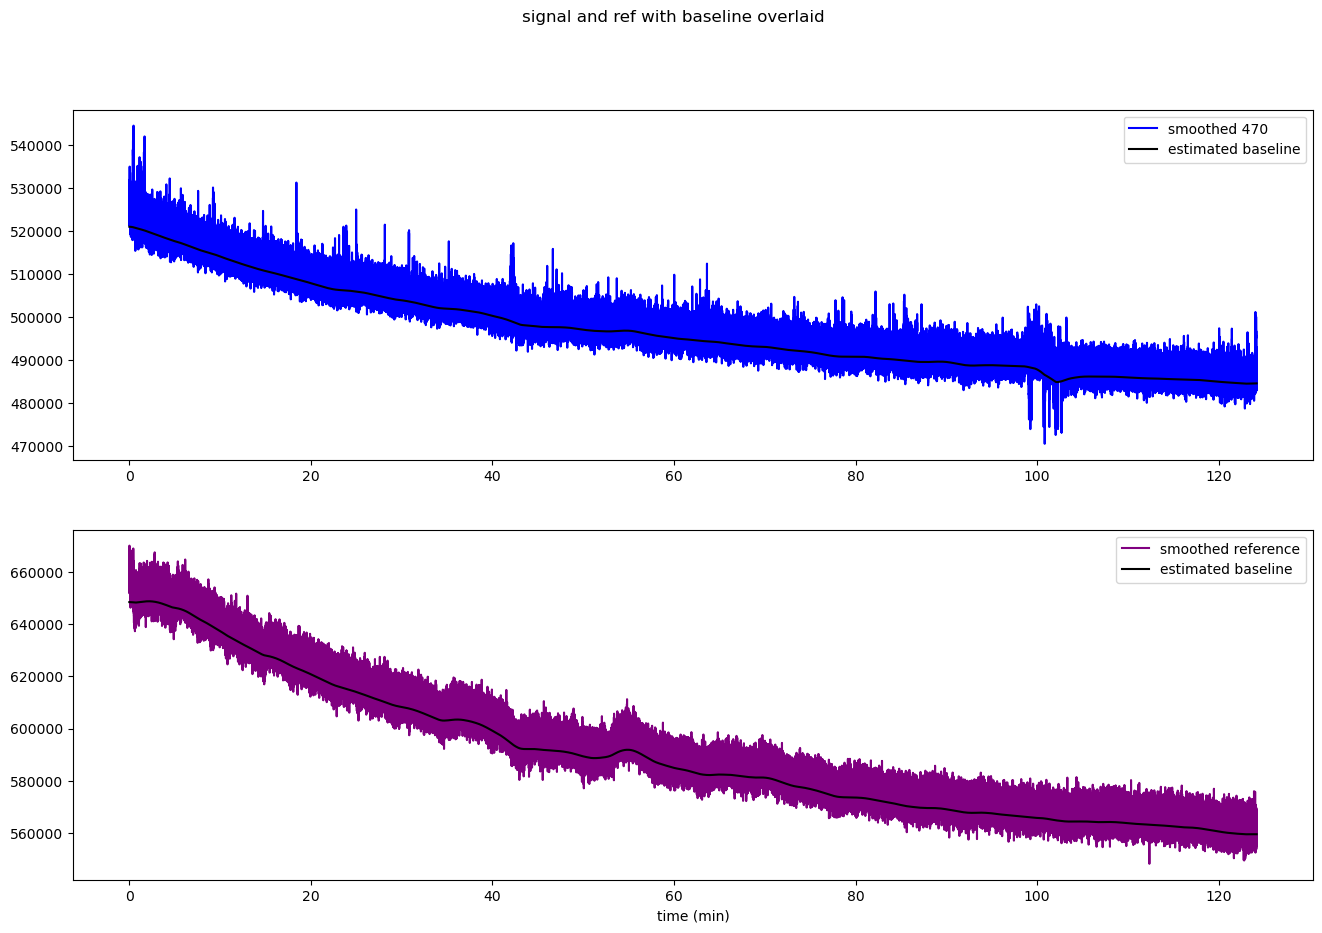

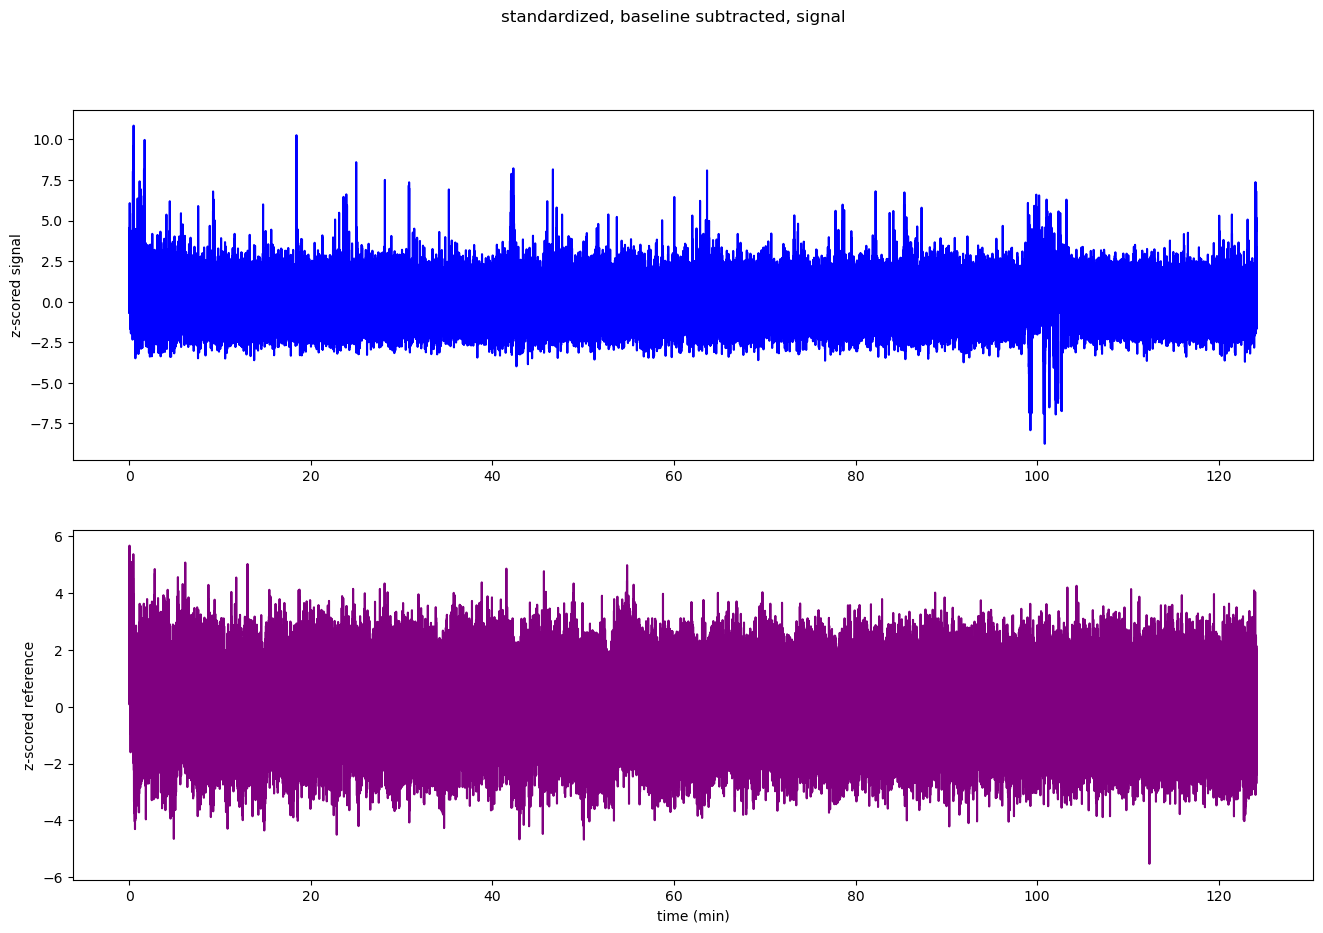

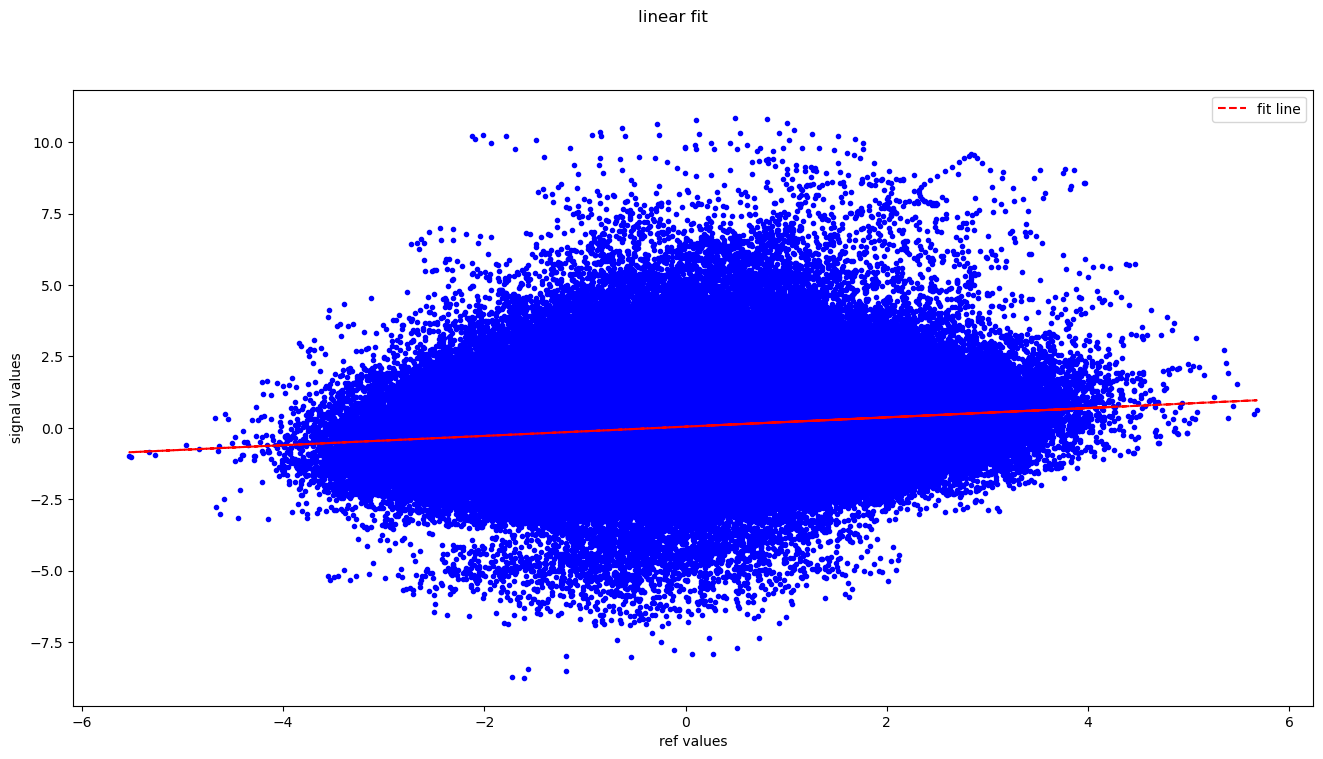

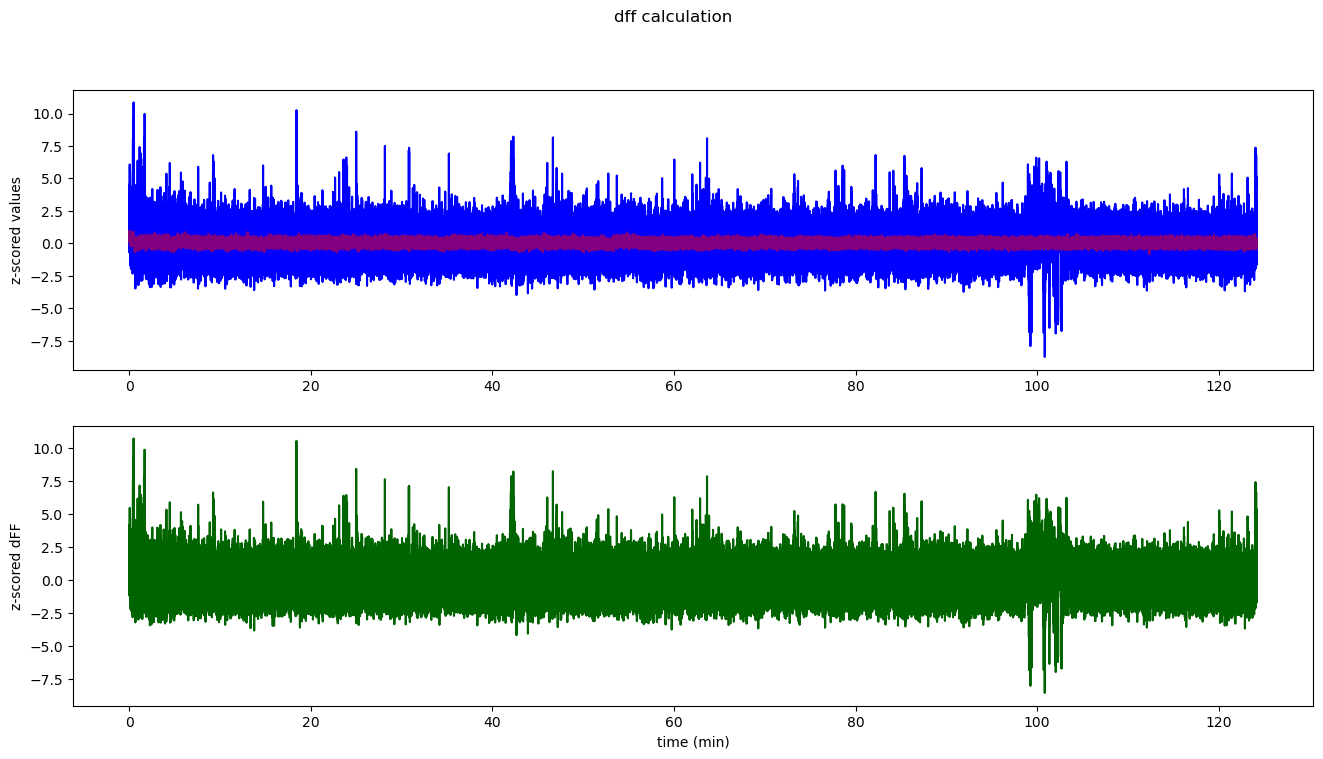

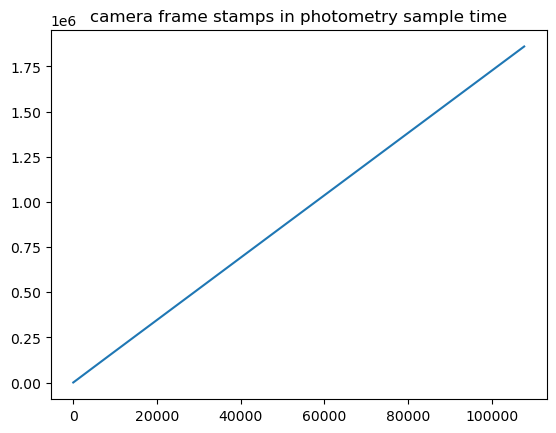

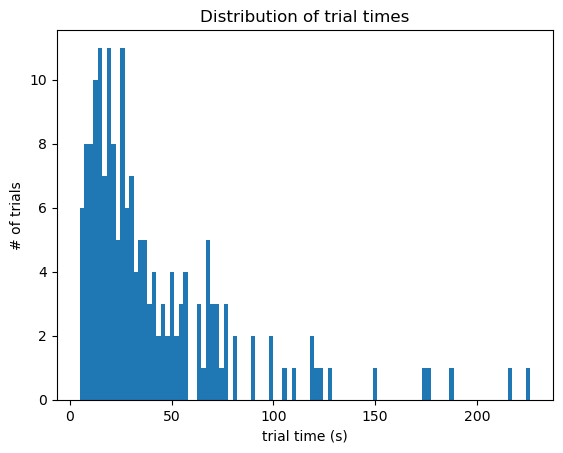

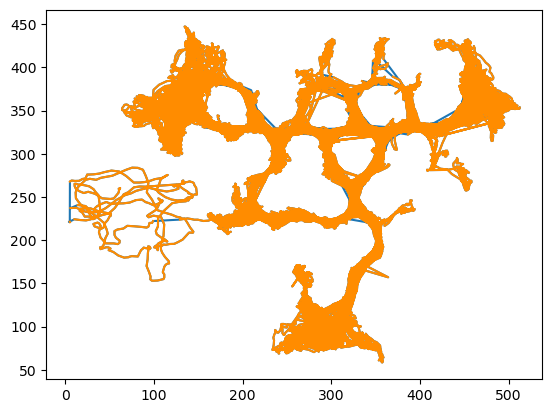

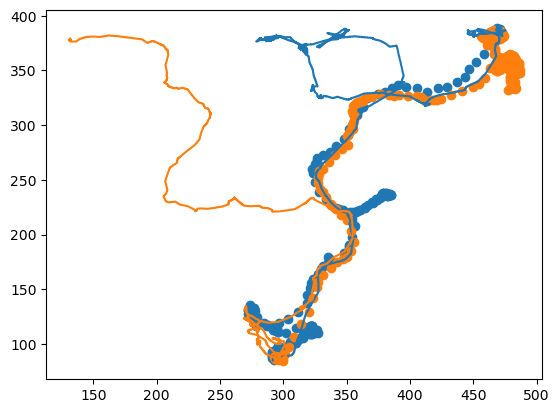

In [12]:
plt.plot(sampledata.loc[visinds[i+0]:visinds[i+1],'x'].interpolate(),sampledata.loc[visinds[i+0]:visinds[i+1],'y'].interpolate())
plt.plot(sampledata.loc[visinds[i+1]:visinds[i+2],'x'].interpolate(),sampledata.loc[visinds[i+1]:visinds[i+2],'y'].interpolate())
i += 1

plt.show()

# if there is an aberrant point in the maze, where DLC labeled the rat every time the cap was obscured, you can nan that out here by specifying the ranges. 
## *Note: this must be done before interpolating between missing position values*

In [12]:
xBadRange = [520,535]
yBadRange = [440,454]
sampledata.loc[(sampledata.x>xBadRange[0])&(sampledata.x<xBadRange[1])\
              &(sampledata.y>yBadRange[0])&(sampledata.y<yBadRange[1]),['x','y']]=np.nan

In [ ]:
plt.figure()
plt.scatter(sampledata.loc[visinds[i+0]:visinds[i+1],'x'],sampledata.loc[visinds[i+0]:visinds[i+1],'y'])
plt.scatter(sampledata.loc[visinds[i+1]:visinds[i+2],'x'],sampledata.loc[visinds[i+1]:visinds[i+2],'y'])
i += 1

# if the video has been labeled using a cropped area, make sure to adjust position to account for the offset. x += 85

In [13]:
sampledata.loc[:,"x"] = sampledata.loc[:,"x"].values+85

# flip y position values to fit with hex map

In [14]:
y_pos = sampledata.y.values
y_midpoint = 480/2
flipped_y_values = y_midpoint + (y_midpoint - y_pos)
sampledata.loc[:,"y"] = flipped_y_values

In [15]:
%matplotlib qt

# adjust hex map to fit the video

In [16]:
import imageio
fname = datepath+'Behav_Vid'+filecount+'.avi'
vid = imageio.get_reader(fname, 'ffmpeg')

from fit_hex_grid import *
hexmap = HexMap(None,None,
                None,ses_type)

### transform_scatter will transform the scatter plot of hexes to fit the new map. the coordinates for each transformed centroid will be stored in the "new_coords" variable (in order of hex ID). You can access the transform parameters in the global variable "transformParams"

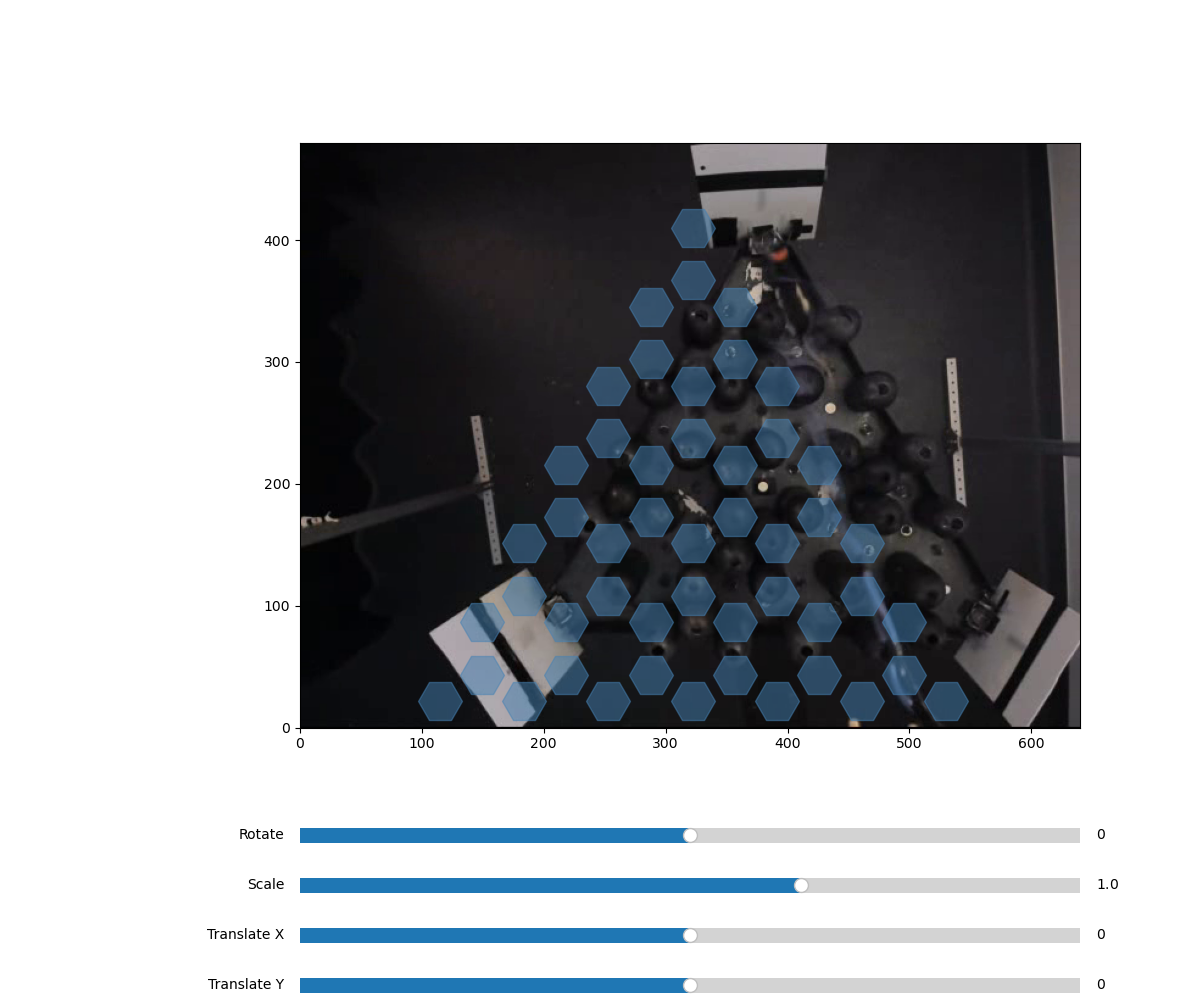

In [17]:
transform_scatter(np.hstack([centroids,np.ones((len(centroids),1))]),vid.get_data(1000),rotate_center=[640/2,480/2])

In [18]:
transformParams

[-1.0576923076923066,
 0.7681410256410255,
 163.71794871794867,
 123.20512820512812]

### save the transform parameters for quick future access

In [19]:
np.save(datepath+"transformparams.npy",transformParams)
print("latest saved in "+datepath+"transformparams.npy")

latest saved in W:/Photometry/IM-1638/04012024/transformparams.npy


### load transform parameters if fit has already been established and saved

In [4]:
paramLoadPath = "W:/Photometry/IM-1594/07252023/"
[rotate_deg,scale,translate_x,translate_y] = np.load(paramLoadPath+"transformparams.npy")

points = np.hstack([centroids,np.ones((len(centroids),1))])

rotate_center=[640/2,480/2]
# Scale
scale_matrix = np.array([[scale, 0, 0],
                         [0, scale, 0],
                         [0, 0, 1]])

# Translate
translate_matrix = np.array([[1, 0, translate_x],
                             [0, 1, translate_y],
                             [0, 0, 1]])

# Rotate
rotate_rad = np.deg2rad(rotate_deg)
rotate_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad), 0],
                          [np.sin(rotate_rad), np.cos(rotate_rad), 0],
                          [0, 0, 1]])

# Rotate around specified center
center_matrix = np.array([[1, 0, rotate_center[0]],
                          [0, 1, rotate_center[1]],
                          [0, 0, 1]])
center_translate_matrix = np.array([[1, 0, -rotate_center[0]],
                                    [0, 1, -rotate_center[1]],
                                    [0, 0, 1]])
rotate_around_center_matrix = center_translate_matrix.dot(rotate_matrix).dot(center_matrix)

# Transform points
transform_matrix = rotate_around_center_matrix.dot(scale_matrix).dot(translate_matrix)
transformed_points = transform_matrix.dot(points.T).T

new_coords = transformed_points[:,:2]

In [25]:
print(rotate_deg,scale,translate_x,translate_y)

NameError: name 'rotate_deg' is not defined

In [20]:
import pandas as pd

# Assuming new_coords is your NumPy array
# Convert it to a Pandas DataFrame
df = pd.DataFrame(new_coords, columns=['x', 'y'])

# Add index as 'hex_label'
df.index = df.index + 1
df.index.name = 'hex_label'

# Save the DataFrame to a CSV file
df.to_csv(filepath + date + "/hex_center_coordinates.csv")

# identify barriers
## *be sure to click on the base of the barrier (where the overlaid hex is), not the top.*

In [21]:
all_bars = []
bind = 0

In [22]:
blocks = sampledata.block.unique()

max ind =  2


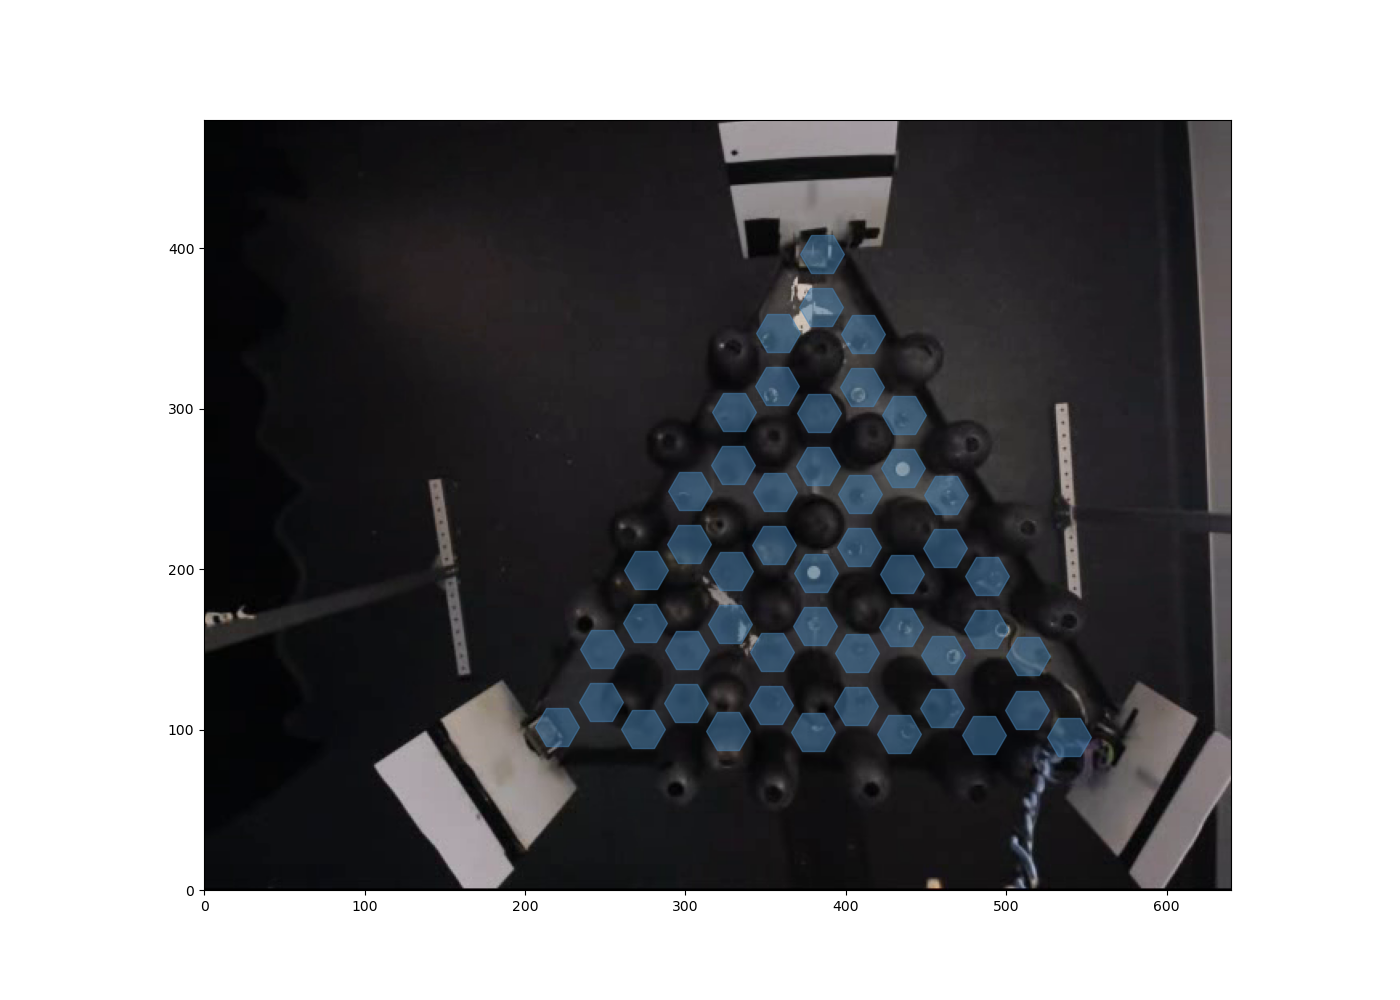

In [29]:
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("x = %d, y = %d" % (ix, iy))
    bar_coords.append((ix, iy))
print('max ind = ',len(blocks)-1)
b = blocks[bind]
ind = int(sampledata.loc[sampledata.block==b].index[int(250*300)]/250*15) #5min into block
fig,ax = plt.subplots(figsize=(14,10))
ax.imshow(vid.get_data(ind), extent=[0, 640, 0, 480])
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
#for h in range(len(hexmap.ids)):
#    plt.text(hexmap.new_hexes[h].centroid.x-10,hexmap.new_hexes[h].centroid.y+10,hexmap.ids[h],\
#            color='whitesmoke',fontweight='demibold')
bar_coords = []
# connect the click event handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# show the plot
plt.show()

In [30]:
bar_coords

[(328.57142857142867, 300.69155844155847),
 (382.8051948051949, 297.57467532467535),
 (273.7142857142858, 200.3279220779221),
 (303.63636363636374, 217.78246753246754),
 (356.0000000000001, 217.78246753246754),
 (434.5454545454546, 197.83441558441558),
 (463.2207792207794, 214.66558441558442),
 (326.07792207792215, 101.8344155844156),
 (485.03896103896113, 98.09415584415585)]

In [31]:
all_bars.append(assign_to_hexagon(np.array(bar_coords)[:,0],np.array(bar_coords)[:,1],new_coords))
bind += 1

# convert position to hex ID

In [32]:
hexes = assign_to_hexagon(sampledata.loc[sampledata.x.notnull(),'x'],sampledata.loc[sampledata.x.notnull(),'y'],new_coords)

## sanity check that position is getting binned in the correct hexes

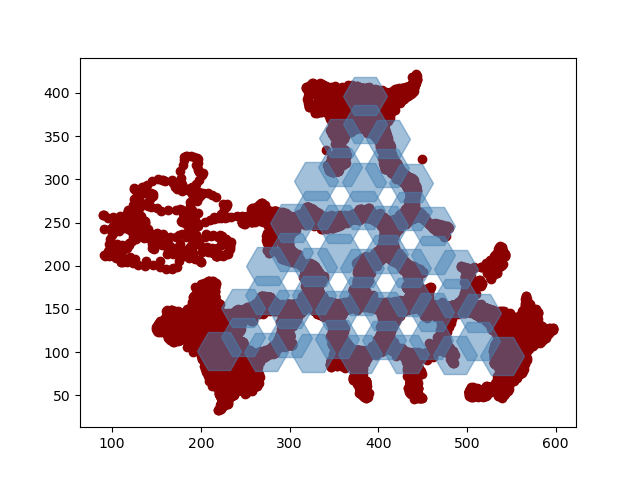

In [33]:
plt.figure()
plt.scatter(sampledata.loc[sampledata.x.notnull(),'x'].values,sampledata.loc[sampledata.x.notnull(),'y'].values,color='darkred')
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

In [34]:
def plot_pos_and_its_hex(i):
    plt.clf()
    plt.scatter(sampledata.loc[sampledata.x.notnull(),'x'].values[i],sampledata.loc[sampledata.x.notnull(),'y'].values[i])
    plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
    plt.scatter(new_coords[hexes[i]-1,0],new_coords[hexes[i]-1,1],marker='H',color='darkred',alpha=0.5,s=1000)

interactive(children=(IntSlider(value=20000, description='frame #:', max=106904, min=1), Output()), _dom_class…

<function __main__.plot_pos_and_its_hex(i)>

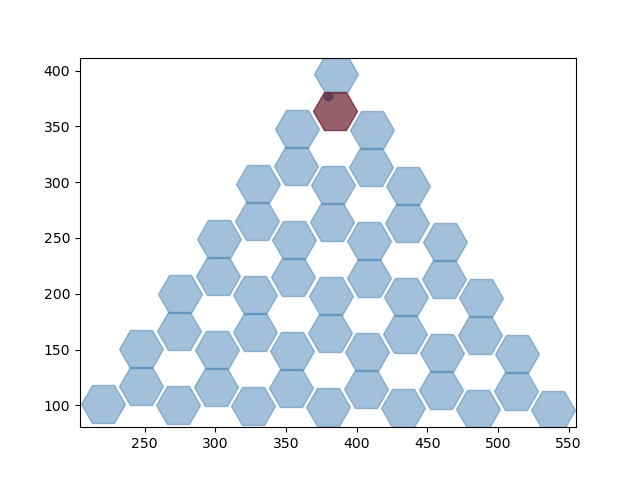

In [35]:
plt.figure()
interact(plot_pos_and_its_hex,i = widgets.IntSlider(
    value=20000,
    min=1,
    max=len(sampledata.loc[sampledata.x.notnull(),'x']),
    step=1,
    description='frame #:'))

In [ ]:
#seshdat = Photrat(animal,date)
#seshdat.df = sampledata

In [36]:
all_bars

[array([11, 10, 21, 27, 19, 30, 36, 46, 43], dtype=int64),
 array([11, 10, 27, 22, 21, 30, 19, 46, 43], dtype=int64),
 array([11, 10, 27, 22, 21, 24, 19, 46, 43], dtype=int64)]

### save the all_bars for quick future access

In [37]:
np.save(datepath+"all_bars.npy",all_bars)
print("latest saved in "+datepath+"all_bars.npy")

latest saved in W:/Photometry/IM-1638/04012024/all_bars.npy


### load all_bars if fit has already been established and saved

In [38]:
all_bars = np.load(datepath+"all_bars.npy")

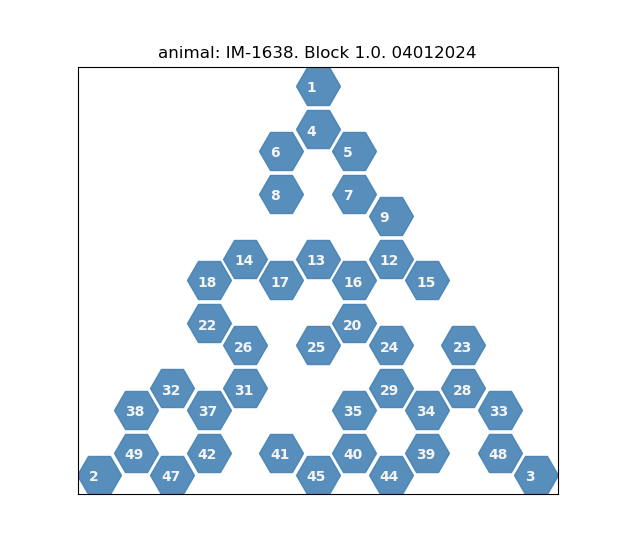

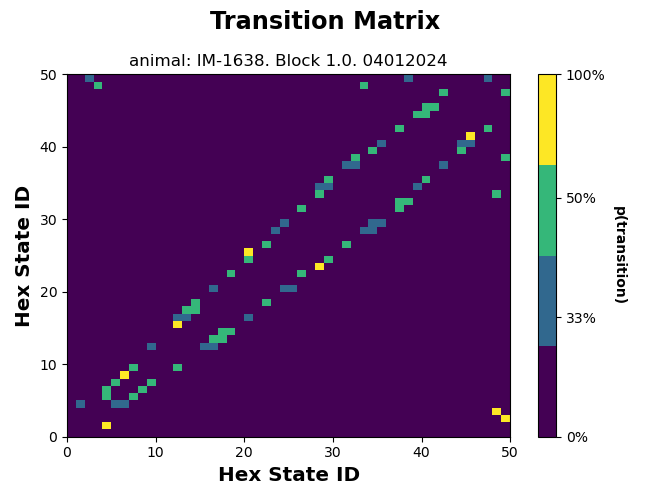

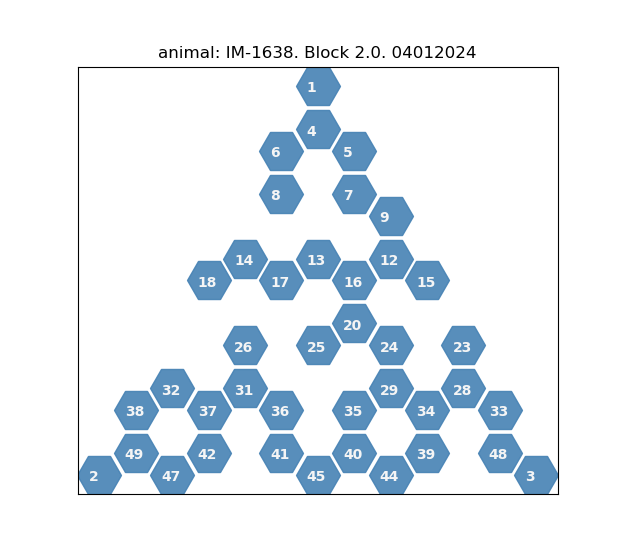

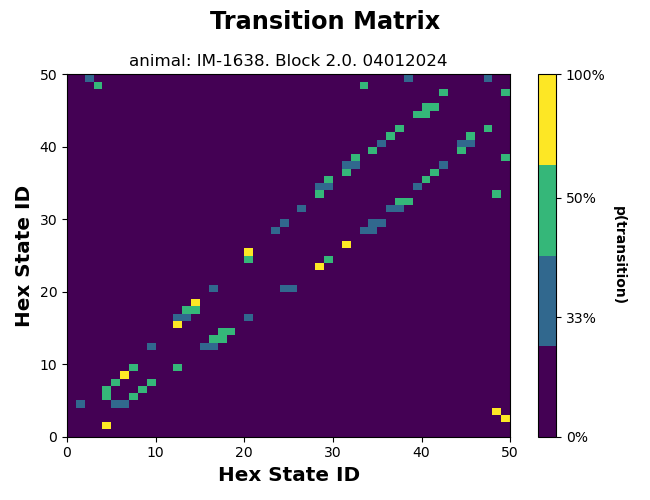

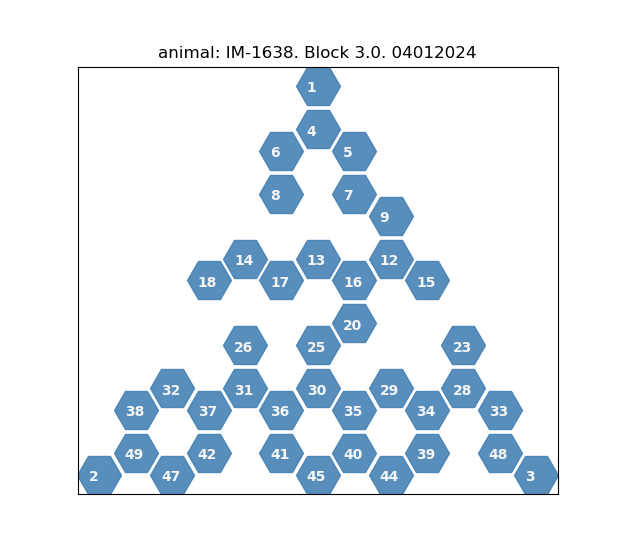

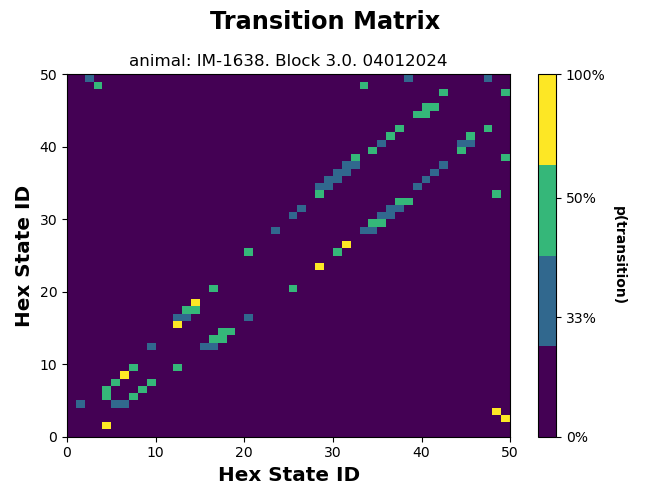

In [39]:
#seshdat.barIDs = np.array(barrier_ids)
#if barrier session, do for each block
#seshdat.tmats = {b:[] for b in np.arange(len(blocks))}
if ses_type == 'barrier':
    segments = []
    branches = []
    for b in range(len(blocks)):
        hexmap.bar_ids = all_bars[b]
        hexmap.bar_ids = [float(f) for f in hexmap.bar_ids]
        mapfig = plot_hex_outline(size='lg',bars=hexmap.bar_ids)
        mapfig.savefig(datepath+"/hex_layout_block"+str(blocks[b])+".pdf")
        plt.title('animal: '+animal+'. Block '+str(blocks[b])+'. '+date)
        transition_matrix = hexmap.plot_sesh_tmat(blocks[b])
        #seshdat.tmats[b] = transition_matrix
        plt.title('animal: '+animal+'. Block '+str(blocks[b])+'. '+date)
        plt.tight_layout()
        np.save(datepath+"/tmat_block_"+str(blocks[b]),transition_matrix)
    np.save(datepath+'/segments',segments)
else:
    hexmap.bar_ids = all_bars[0]
    hexmap.bar_ids = [float(f) for f in hexmap.bar_ids]
    mapfig = plot_hex_outline(size='lg',bars=hexmap.bar_ids)
    mapfig.savefig(datepath+"/hex_layout.pdf")
    plt.title('animal: '+animal+'. '+date)
    transition_matrix = hexmap.plot_sesh_tmat()
    #seshdat.tmats[0] = transition_matrix
    plt.title('animal: '+animal+'. '+date)
    plt.tight_layout()
    np.save(datepath+"/tmat",transition_matrix)

#only when you have island

In [44]:
all_bars[2]

IndexError: list index out of range

In [ ]:
#only when you have island
all_bars[2] = np.concatenate([all_bars[2],[11]])

# mark critical choice points (where rat has option to choose one port with left choice, and a different port with right choice)

In [40]:
crit_cps = [[16],[40,29],[30,36]]
if ses_type == 'barrier':
    for b in range(len(blocks)):
        np.save(datepath+"/cps_block_"+str(blocks[b]),crit_cps[b])
else:
    np.save(datepath+"/cps",crit_cps[0])

In [15]:
print(np.load('W:/Photometry/IM-1594/07262023/cps_block_5.0.npy'))

[29 35]


# add hexes to dataframe

In [41]:
sampledata.loc[:,'hexlabels'] = -1
sampledata.loc[sampledata.x.notnull(),'hexlabels'] = hexes
sampledata.loc[:,'hexlabels'] = sampledata.loc[:,'hexlabels'].replace(-1,method='ffill')

C:\Users\yangsunhwang\AppData\Local\Temp\ipykernel_2188\3432592372.py:3: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sampledata.loc[:,'hexlabels'] = sampledata.loc[:,'hexlabels'].replace(-1,method='ffill')


# save final dataframe

In [42]:
sampledata.to_csv(savepath+animal+'_'+date+'_'+'h_sampleframe.csv')

## check and save reward response of DA

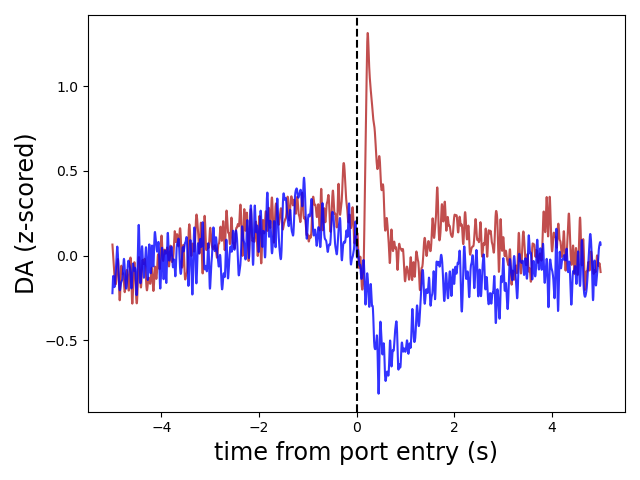

In [43]:
rwd_traces = []
om_traces = []
xvals = np.arange(-5*250,5*250+1)/250
for i in visinds:
    if sampledata.loc[i,'rwd']==1:
        rwd_traces.append(sampledata.loc[i-250*5:i+250*5,"green_z_scored"].values)
    else:
        trace = sampledata.loc[i-250*5:i+250*5,"green_z_scored"].values
        if len(trace)==len(xvals):
            om_traces.append(trace)
fig = plt.figure()
plt.plot(xvals,np.mean(rwd_traces,axis=0),color='firebrick',alpha=0.8)
plt.plot(xvals,np.mean(om_traces,axis=0),color='blue',alpha=0.8)
plt.axvline(x=0,ls='--',color='k')
plt.xlabel("time from port entry (s)",fontsize='xx-large')
plt.ylabel("DA (z-scored)",fontsize='xx-large')
plt.tight_layout()
fig.savefig(datepath+"meanRwdOmRespone.pdf")